# E04_나만의 이미지 분류기 만들어보기

## 1. dataset 내려받기

In [56]:
# pkg 버전으로 인한 경고메세지 출력시 꼭 필요한 경고 메시지만 출력되도록 하기
import warnings
warnings.filterwarnings("ignore")

In [57]:
import tensorflow as tf



gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [58]:
import tensorflow_datasets as tfds

In [59]:
# data load
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [60]:


# data check
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


## 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기
이미지를 모두 같은 크기로 formatting 한 후, `train_batches`, `validation_batches`, `test_batches`를 준비합니다.

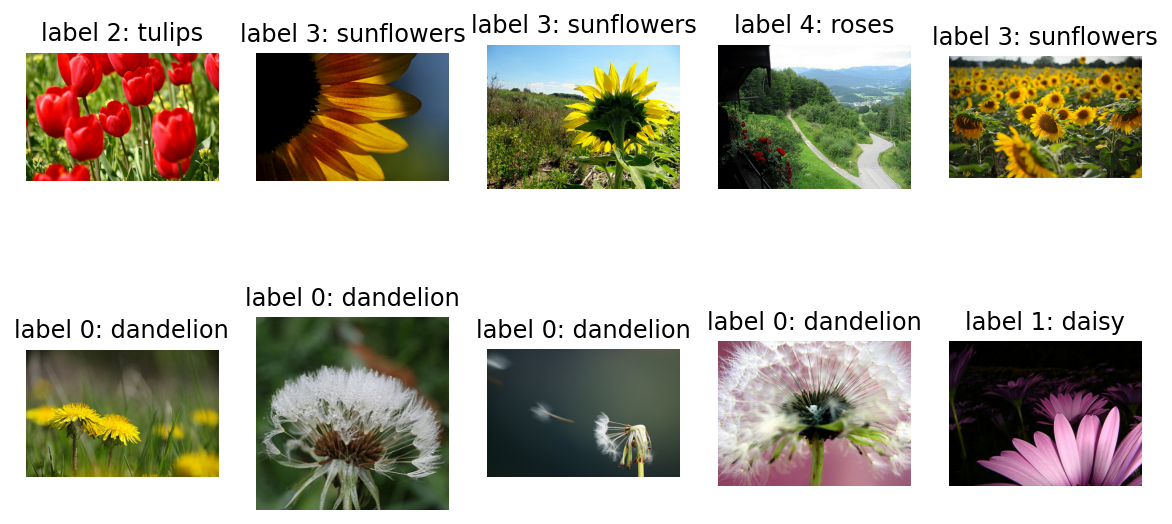

In [61]:
# 데이터를 확인하기 위한 matplotlib라이브러리 가져오기
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

# 0: dandelion  1: daisy   2: tulips   3: sunflowers   4: roses

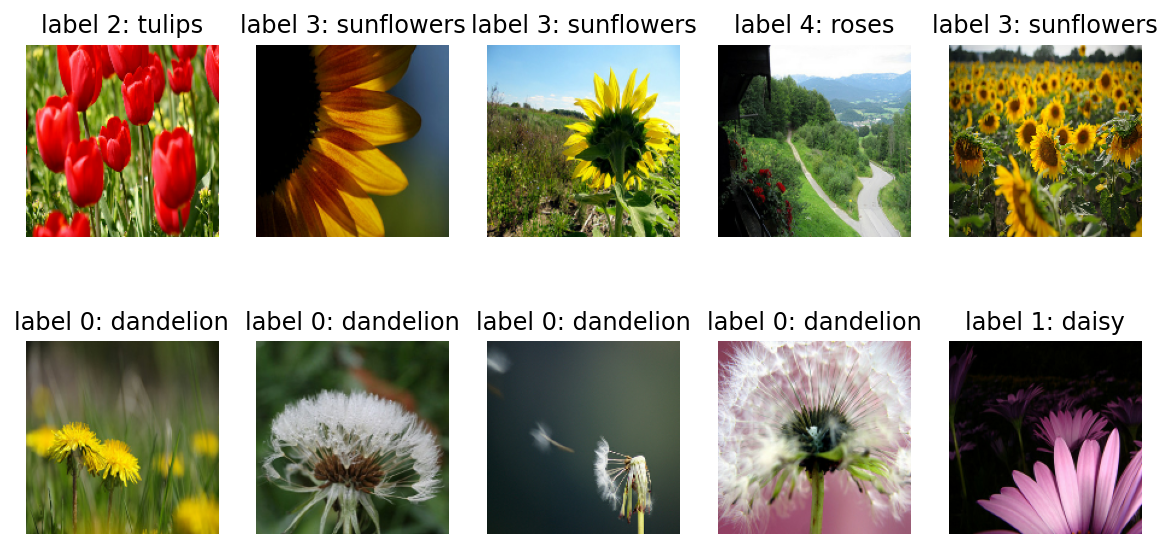

In [62]:
# 160x160, pixel scale fix
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

# 다듬은 데이터셋 사진 출력해보기
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## 3. 모델 설계하기

In [63]:
# models : 모델 자체 구축위한 함수
# layers : 모델의 구성 요소인 여러 레이어, 즉 "층" 이라는 함수들을 갖고있다
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

#base_learning_rate = 0.0001
#model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
#              loss=tf.keras.losses.sparse_categorical_crossentropy,
#              metrics=['accuracy'])

In [64]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [65]:
# train_batches에서 하나의 batch만 꺼내 데이터 확인해보기
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([10, 160, 160, 3]), TensorShape([10]))

In [66]:
# 잘 학습된 모델 가져오기
# 이미지 인풋을 받아 해당 이미지의 특징을 잘 뽑아낸 특징 벡터를 추출해낼 수 있다
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')


# 모델 구조 확인
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

### 실제 모델에 이미지 데이터 넣어보기

In [67]:
feature_batch = base_model(image_batch)

In [68]:
# 모델에 배치를 넣은 결과 shape
feature_batch.shape

TensorShape([10, 5, 5, 512])

In [69]:
# global average pooling
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# global_average_layer에 위에서 VGG16이 출력했던 feature_batch를 입력
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 512)


In [70]:
# 마지막으로 Dense 레이어들을 붙여주면 custumized classifier가 완성됨
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

# vgg16 에 해당하는 base_model은 학습을 시키지 않을 예정이니 
# 학습 여부를 결정하는 trainable변수를 False로 설정한다
base_model.trainable = False

(10, 5)


In [71]:


# 최종 모델 만들기
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

# 최종 모델 구조 확인하기
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


In [72]:
# 모델을 compile하면 끝
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# 위 과정과 동일하게 초기 손실, 정확도 값 계산하기
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 1s 26ms/step - loss: 1.8034 - accuracy: 0.1600
initial loss: 1.80
initial accuracy: 0.16


## 4. model 학습시키기

In [78]:
import time
start=time.time()

# 모델 학습 시작
EPOCHS = 5   # 이번에는 이전보다 훨씬 빠르게 수렴되므로 5Epoch이면 충분합니다.

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

print('VGG16 걸린 시간:',time.time()-start)

Epoch 1/5
294/294 [==============================] - 10s 34ms/step - loss: 1.2019 - accuracy: 0.6066 - val_loss: 0.9106 - val_accuracy: 0.7248
Epoch 2/5
294/294 [==============================] - 10s 33ms/step - loss: 0.8168 - accuracy: 0.7459 - val_loss: 0.7512 - val_accuracy: 0.7384
Epoch 3/5
294/294 [==============================] - 10s 34ms/step - loss: 0.6826 - accuracy: 0.7820 - val_loss: 0.6339 - val_accuracy: 0.7766
Epoch 4/5
294/294 [==============================] - 10s 35ms/step - loss: 0.6098 - accuracy: 0.7977 - val_loss: 0.5865 - val_accuracy: 0.7847
Epoch 5/5
294/294 [==============================] - 10s 36ms/step - loss: 0.5627 - accuracy: 0.8096 - val_loss: 0.5673 - val_accuracy: 0.8038
VGG16 걸린 시간: 53.06278371810913


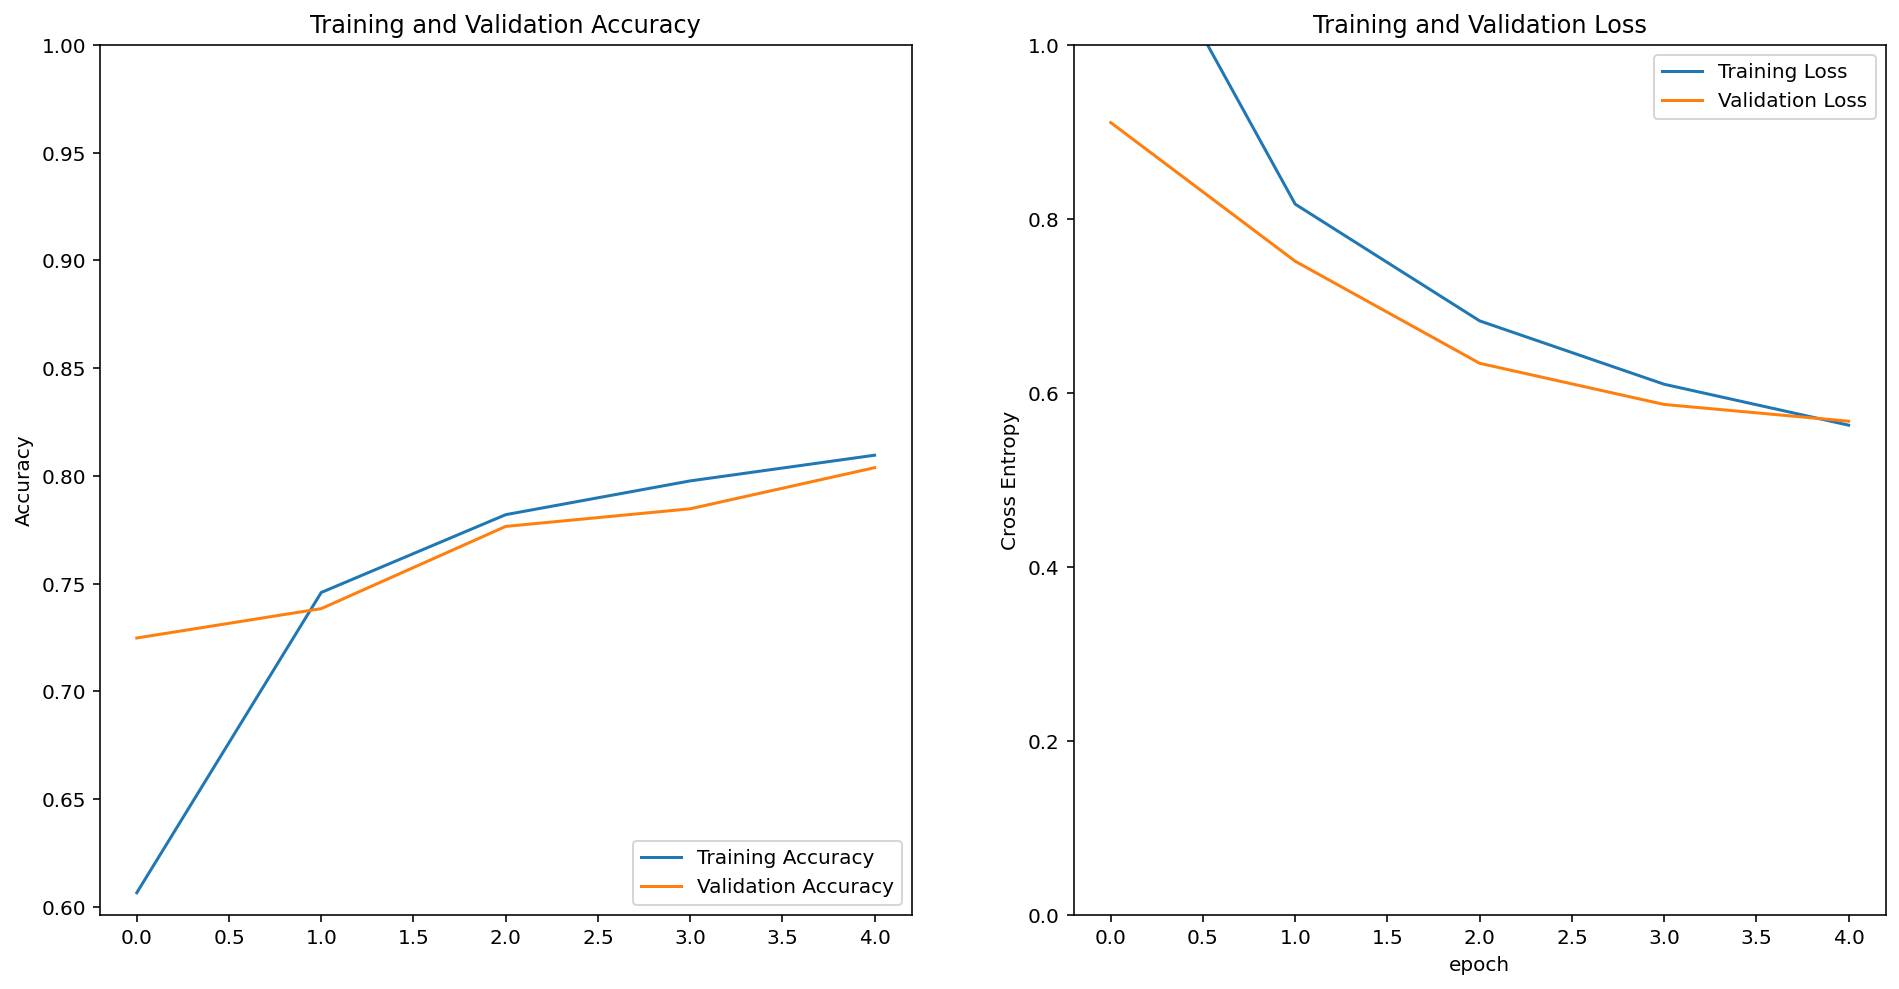

In [79]:
# 그래프로 학습 과정 추이도 확인하기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [80]:
# 손실, 정확도 값 계산하기
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = test_steps)

print("validation loss: {:.2f}".format(loss0))
print("validation accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 1s 28ms/step - loss: 0.5807 - accuracy: 0.7900
test loss: 0.58
test accuracy: 0.79


#  5. model 성능 평가하기

In [81]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

# 역시 0과 4 사이의 값으로 확률값을 출력함

array([[2.99207624e-02, 1.22960351e-01, 6.15904629e-01, 7.39010945e-02,
        1.57313213e-01],
       [9.98582602e-01, 1.06461230e-03, 1.95567300e-05, 1.91768675e-04,
        1.41583543e-04],
       [7.42102504e-01, 1.28814772e-01, 1.98489465e-02, 8.63445327e-02,
        2.28892155e-02],
       [3.35853989e-03, 2.29494814e-02, 4.96991485e-01, 8.47217254e-03,
        4.68228340e-01],
       [5.70576549e-01, 3.57750535e-01, 1.91998687e-02, 1.92483999e-02,
        3.32245938e-02],
       [8.95360053e-01, 6.84217885e-02, 5.21152839e-03, 2.82188561e-02,
        2.78784148e-03],
       [1.46267023e-02, 2.14865915e-02, 6.48474395e-01, 1.92214653e-01,
        1.23197660e-01],
       [4.15075600e-01, 4.12612468e-01, 2.20621750e-03, 1.60252303e-01,
        9.85346641e-03],
       [1.99050140e-02, 5.45050809e-03, 3.19855995e-02, 8.29994380e-01,
        1.12664446e-01],
       [9.99183953e-01, 6.64603140e-04, 2.25443478e-06, 1.41930592e-04,
        7.31620003e-06]], dtype=float32)

In [82]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 0, 3, 0])

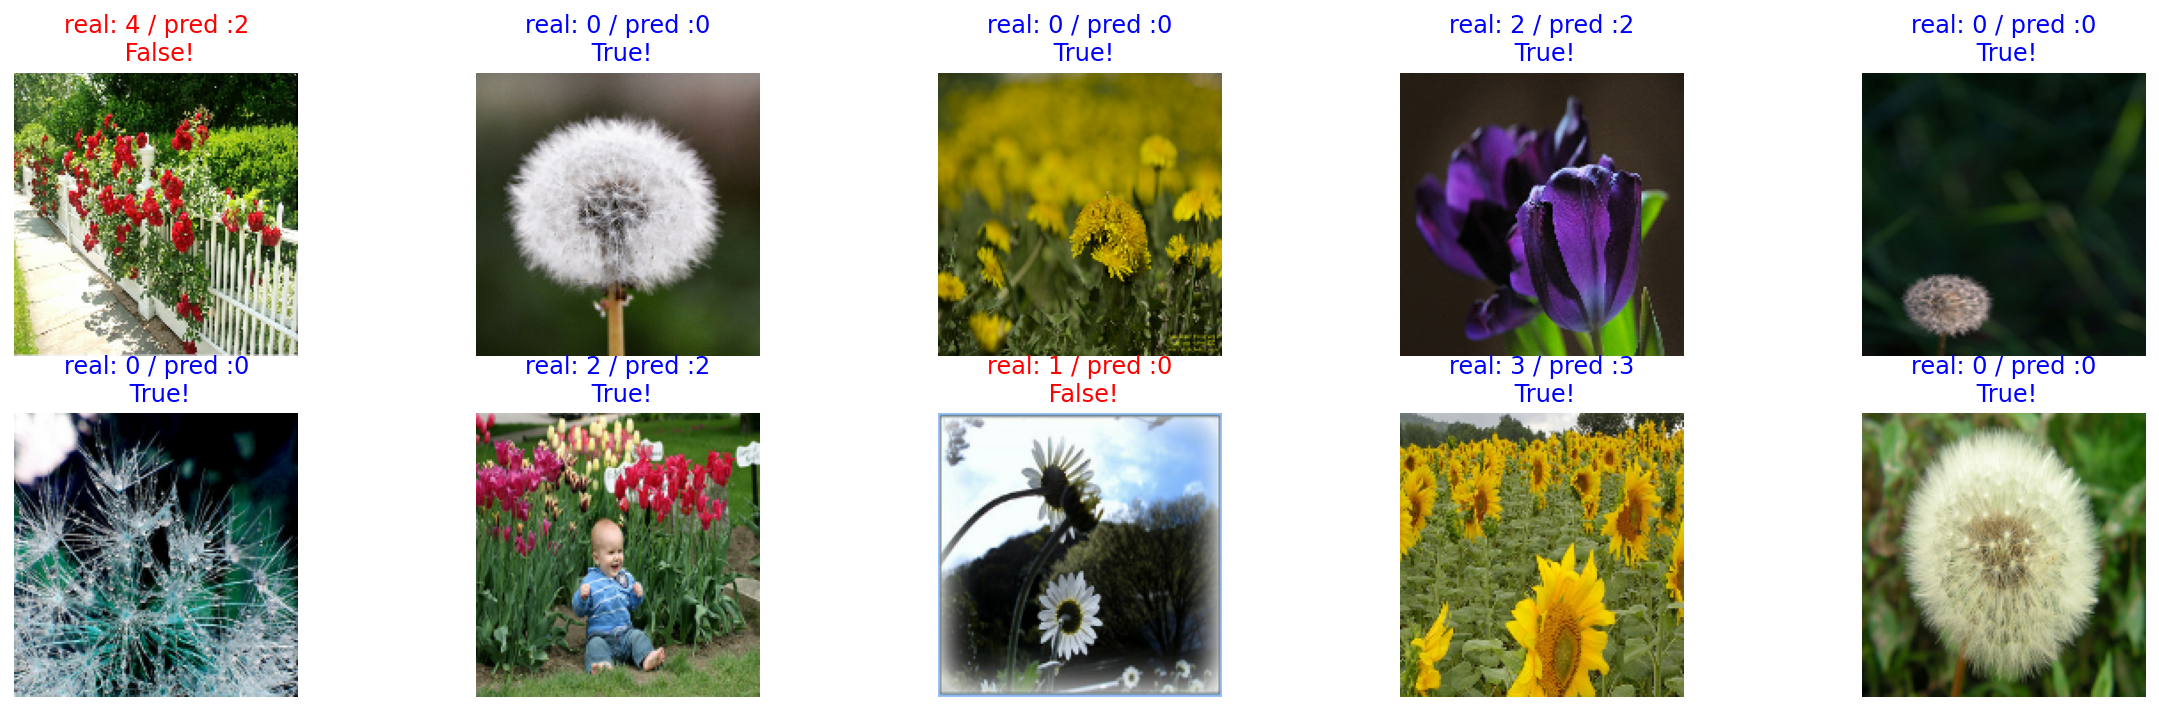

In [83]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [84]:
# 10개에 대한 정확도 확인
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 10 * 100)

80.0


# 6. model 활용하기

In [85]:
# 첫 번째 모델 저장하기
import os

checkpoint_dir = os.getenv("HOME") + "/aiffel/e/E04_dogcat_classifier/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


### 실제 예측하기

In [86]:
img_dir_path = os.getenv("HOME") + "/aiffel/e/E04_dogcat_classifier/images"
os.path.exists(img_dir_path)

True

In [89]:
# 0: dandelion  1: daisy   2: tulips   
# 3: sunflowers   4: roses

from tensorflow.keras.preprocessing.image import load_img, img_to_array

def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    dandel_percentage = round(prediction[0] * 100)
    daisy_percentage = round(prediction[1] * 100)
    tulips_percentage = round(prediction[2] * 100)
    sunflowers_percentage = round(prediction[3] * 100)
    roses_percentage = round(prediction[4] * 100)
    print(f"This image seems {dandel_percentage}% dandelion, and {daisy_percentage}% daisy.")
    print(f"And it's {tulips_percentage}% tulips, {sunflowers_percentage}% sunflowers and finally {roses_percentage}% roses.")

## model: VGG16

This image seems 0.0% dandelion, and 0.0% daisy.
And it's 0.0% tulips, 0.0% sunflowers and finally 100.0% roses.


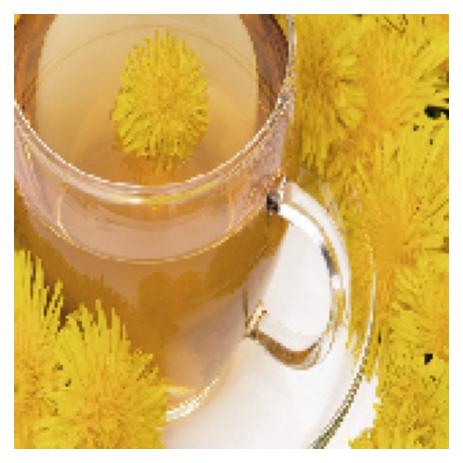

In [98]:
# 함수 실행
filename = 'dandel.jpg'
show_and_predict_image(img_dir_path, filename)

This image seems 0.0% dandelion, and 0.0% daisy.
And it's 100.0% tulips, 0.0% sunflowers and finally 0.0% roses.


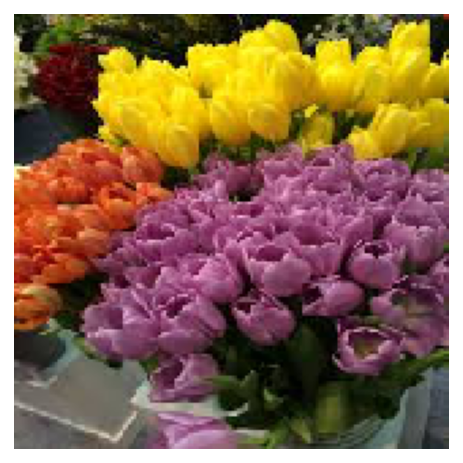

In [91]:
filename = 't1.jpeg'
show_and_predict_image(img_dir_path, filename)

This image seems 0.0% dandelion, and 98.0% daisy.
And it's 2.0% tulips, 0.0% sunflowers and finally 0.0% roses.


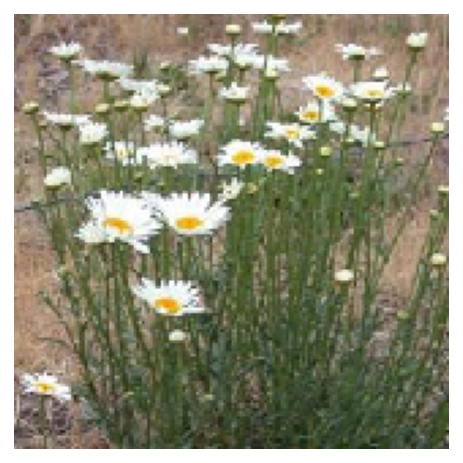

In [92]:
filename = 'daisy3.jpg'
show_and_predict_image(img_dir_path, filename)

This image seems 0.0% dandelion, and 0.0% daisy.
And it's 0.0% tulips, 0.0% sunflowers and finally 100.0% roses.


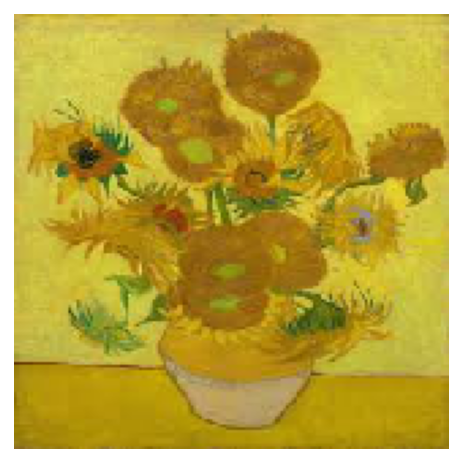

In [93]:
filename = 'sunf2.jpeg'
show_and_predict_image(img_dir_path, filename)

This image seems 0.0% dandelion, and 0.0% daisy.
And it's 1.0% tulips, 0.0% sunflowers and finally 99.0% roses.


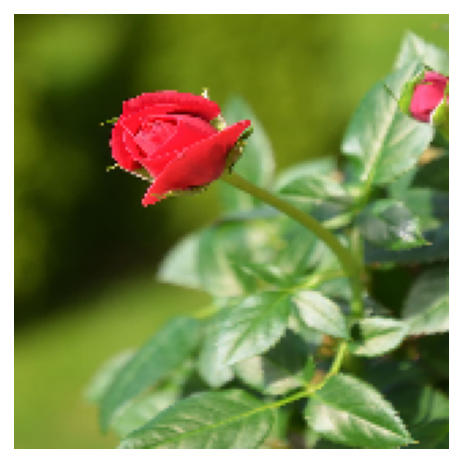

In [94]:
filename = 'roses2.jpg'
show_and_predict_image(img_dir_path, filename)

# model : mobilenet

In [100]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [101]:
# train_batches에서 하나의 batch만 꺼내 데이터 확인해보기
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([10, 160, 160, 3]), TensorShape([10]))

In [102]:
# 잘 학습된 모델 가져오기
# 이미지 인풋을 받아 해당 이미지의 특징을 잘 뽑아낸 특징 벡터를 추출해낼 수 있다
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')


# 모델 구조 확인
base_model.summary()

17227776/17225924 [==============================] - 3s 0us/step
Model: "mobilenet_1.00_160"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 161, 161, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_________________________________________________

In [103]:
feature_batch = base_model(image_batch)

In [104]:
feature_batch.shape

TensorShape([10, 5, 5, 1024])

In [105]:
# global average pooling
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# global_average_layer에 위에서 VGG16이 출력했던 feature_batch를 입력
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# 마지막으로 Dense 레이어들을 붙여주면 custumized classifier가 완성됨
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')


(10, 1024)


In [106]:
# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

# vgg16 에 해당하는 base_model은 학습을 시키지 않을 예정이니 
# 학습 여부를 결정하는 trainable변수를 False로 설정한다
base_model.trainable = False

(10, 5)


In [107]:
# 최종 모델 만들기
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

# 최종 모델 구조 확인하기
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_160 (Model)   (None, 5, 5, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 2565      
Total params: 3,756,229
Trainable params: 527,365
Non-trainable params: 3,228,864
_________________________________________________________________


In [108]:
# 모델을 compile하면 끝
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# 위 과정과 동일하게 초기 손실, 정확도 값 계산하기
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 0s 6ms/step - loss: 2.1436 - accuracy: 0.2400
initial loss: 2.14
initial accuracy: 0.24


In [109]:
# 모델 학습시키기
import time
start=time.time()

# 모델 학습 시작
EPOCHS = 5   # 이번에는 이전보다 훨씬 빠르게 수렴되므로 5Epoch이면 충분합니다.

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

print('MobileNet 걸린 시간:',time.time()-start)

Epoch 1/5
294/294 [==============================] - 32s 107ms/step - loss: 0.5809 - accuracy: 0.7905 - val_loss: 0.3753 - val_accuracy: 0.8665
Epoch 2/5
294/294 [==============================] - 3s 9ms/step - loss: 0.2670 - accuracy: 0.9063 - val_loss: 0.3236 - val_accuracy: 0.8828
Epoch 3/5
294/294 [==============================] - 3s 9ms/step - loss: 0.1787 - accuracy: 0.9435 - val_loss: 0.3350 - val_accuracy: 0.8801
Epoch 4/5
294/294 [==============================] - 3s 9ms/step - loss: 0.1278 - accuracy: 0.9629 - val_loss: 0.2973 - val_accuracy: 0.8937
Epoch 5/5
294/294 [==============================] - 3s 9ms/step - loss: 0.0900 - accuracy: 0.9772 - val_loss: 0.3281 - val_accuracy: 0.8883
MobileNet 걸린 시간: 45.267476081848145


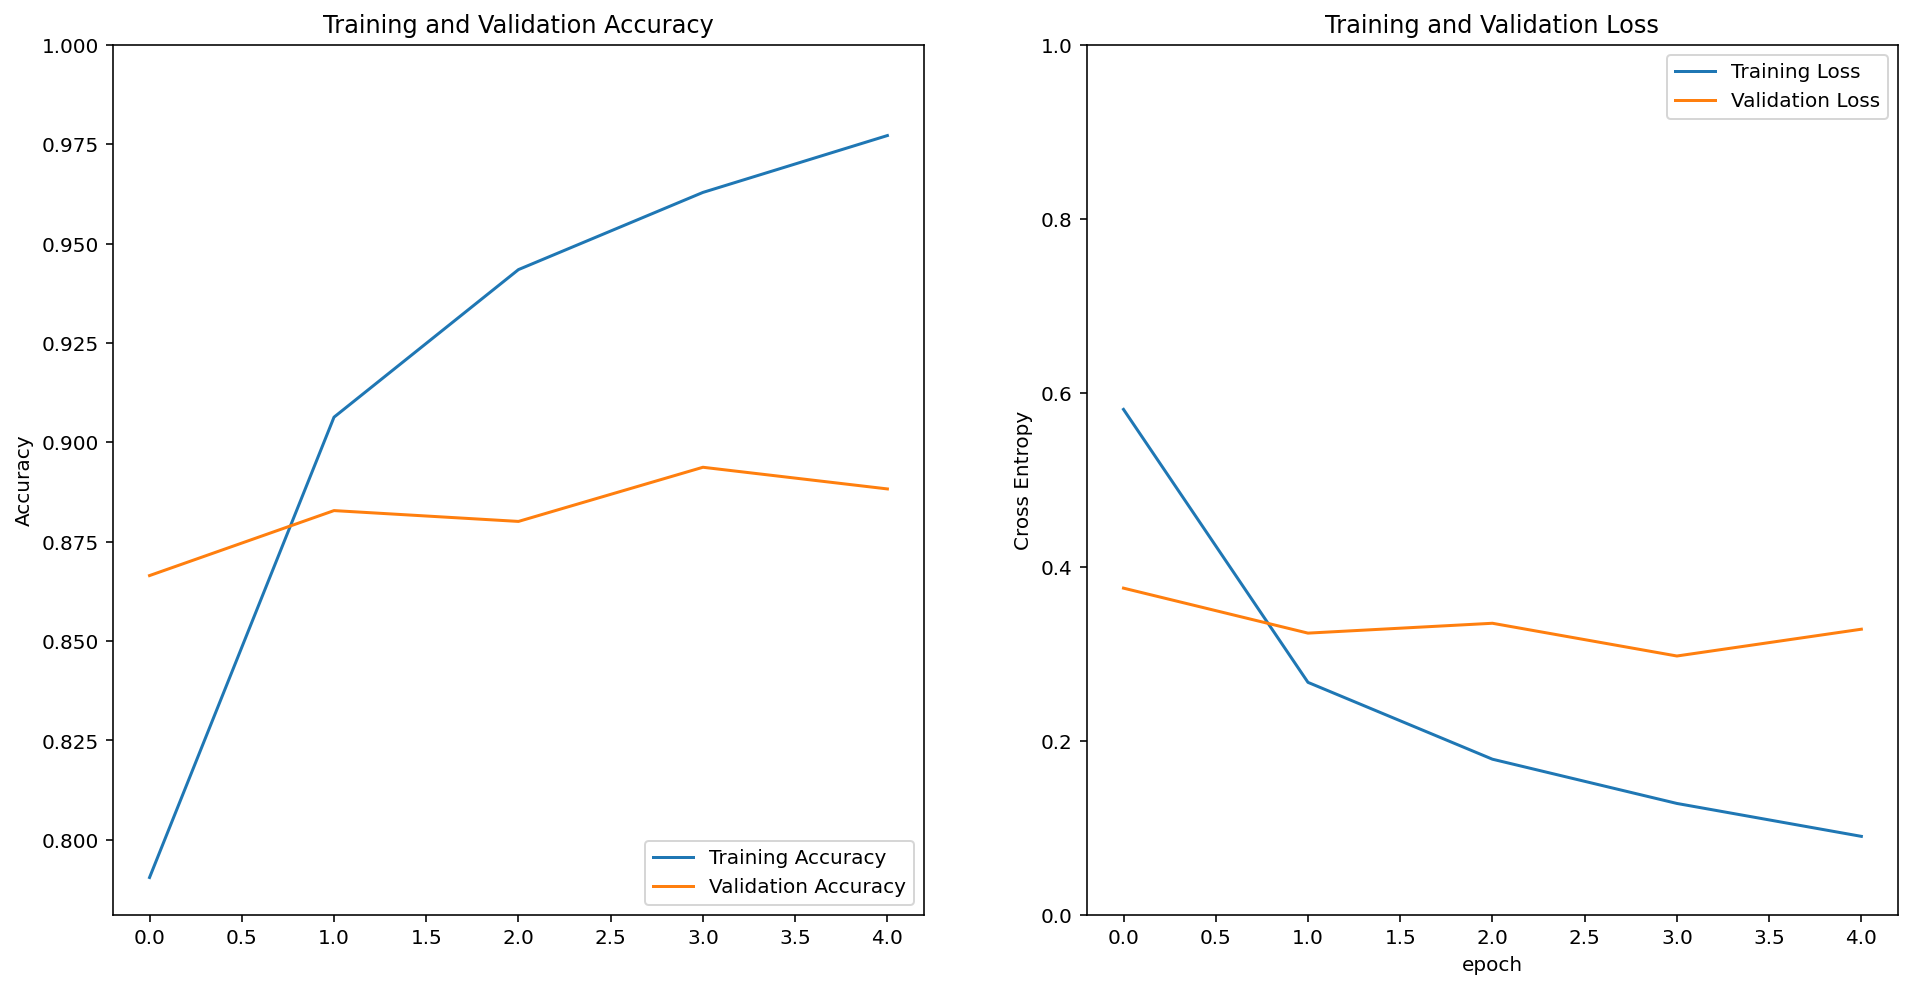

In [110]:
# 그래프로 학습 과정 추이도 확인하기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [111]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

# 역시 0과 1 사이의 값으로 확률값을 출력함
# 이번에도 prediction 값들을 실제 추론한 라벨(고양이:0, 강아지:1)로 변

array([[6.52112765e-04, 1.42103687e-04, 9.18663621e-01, 7.98740014e-02,
        6.68098801e-04],
       [9.99999762e-01, 1.14605740e-07, 1.53094852e-08, 4.51904292e-08,
        3.40776474e-08],
       [8.86837065e-01, 1.55119051e-05, 3.41946543e-05, 1.13078944e-01,
        3.42897474e-05],
       [5.95426478e-04, 1.40245259e-03, 9.66395736e-01, 1.32229654e-02,
        1.83834489e-02],
       [9.98379230e-01, 7.86007906e-04, 9.42337738e-06, 7.38388218e-04,
        8.69506403e-05],
       [9.99351799e-01, 2.41325994e-04, 4.61004529e-05, 3.60091653e-04,
        5.51574942e-07],
       [1.70930361e-04, 7.03046226e-06, 9.98106956e-01, 1.69536297e-03,
        1.96244473e-05],
       [4.63028550e-02, 5.71303666e-01, 2.43391696e-05, 3.82353753e-01,
        1.53785095e-05],
       [3.65672255e-04, 6.17134566e-09, 1.99204292e-02, 9.79706645e-01,
        7.21371725e-06],
       [9.99984264e-01, 2.62005210e-06, 8.16792726e-06, 4.32175830e-06,
        6.22945151e-07]], dtype=float32)

In [112]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0])

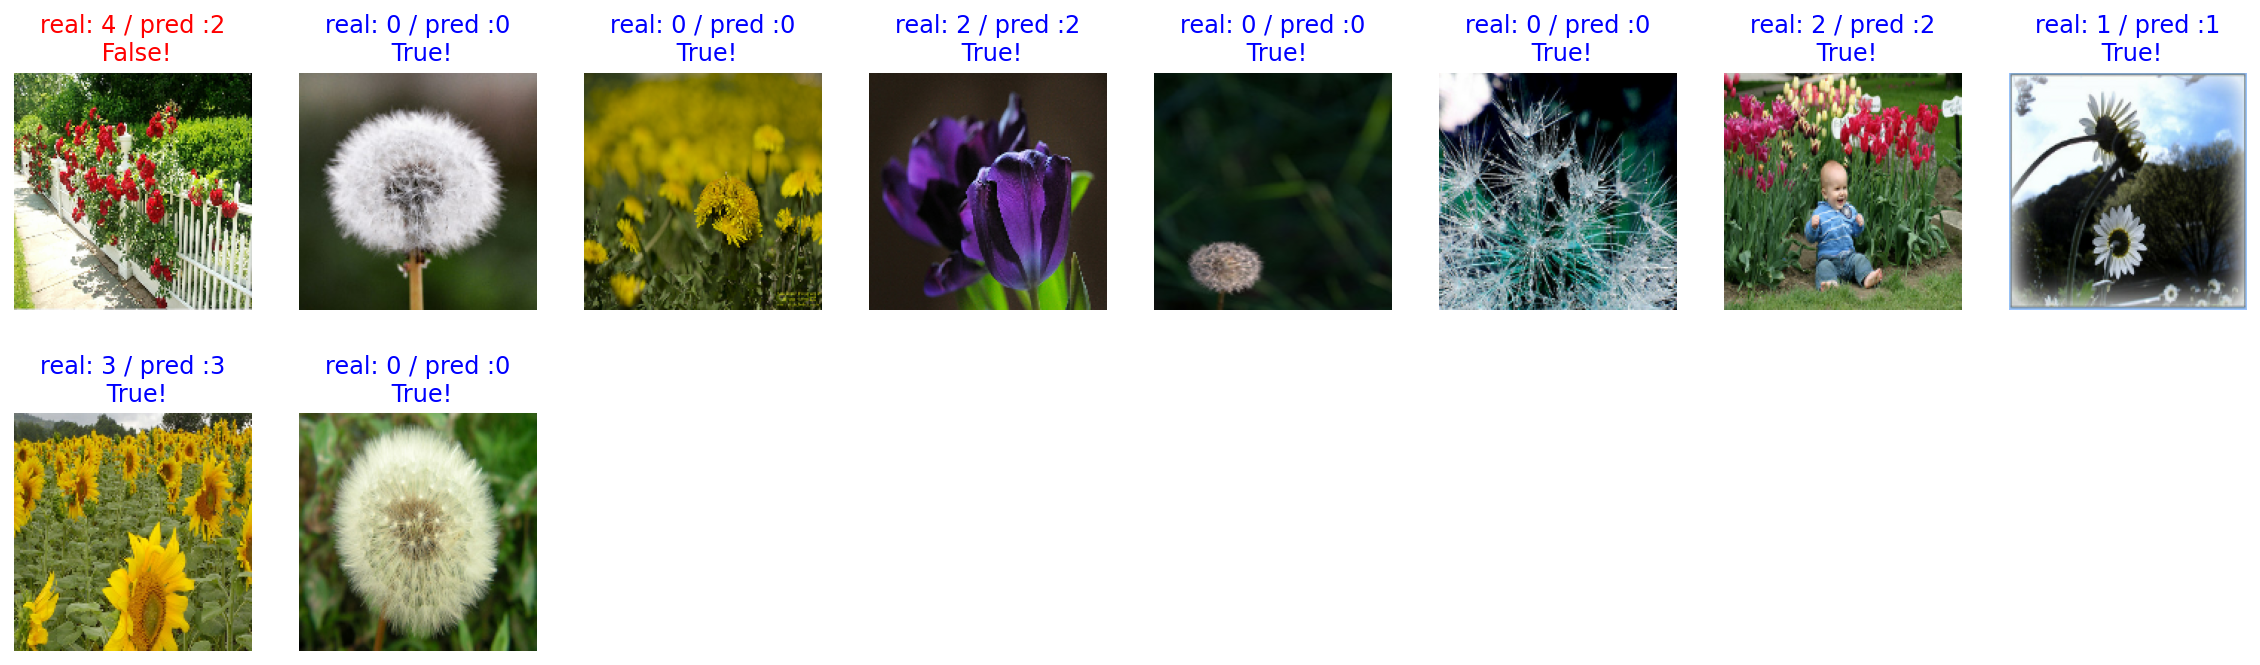

In [113]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [114]:
# 10개에 대한 정확도 확인
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 10 * 100) 

90.0


## mobilenet real-world predict

In [115]:
# 실제 이미지 가져와서 예측하기
img_dir_path = os.getenv("HOME") + "/aiffel/e/E04_dogcat_classifier/images"
os.path.exists(img_dir_path)

True

This image seems 36.0% dandelion, and 0.0% daisy.
And it's 51.0% tulips, 0.0% sunflowers and finally 12.0% roses.


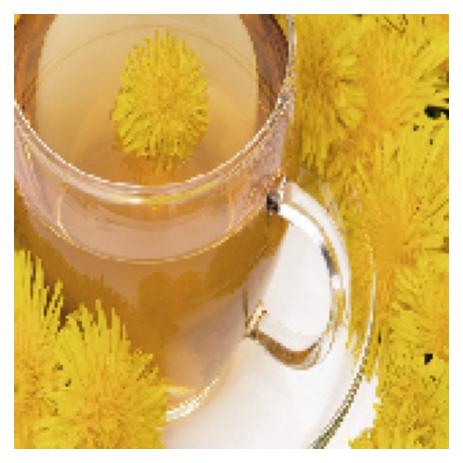

In [116]:
# 이미지 실행
# 함수 실행
filename = 'dandel.jpg'
show_and_predict_image(img_dir_path, filename)


This image seems 1.0% dandelion, and 1.0% daisy.
And it's 94.0% tulips, 0.0% sunflowers and finally 4.0% roses.


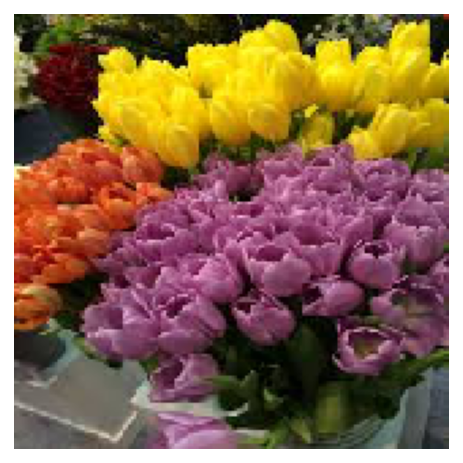

In [117]:

filename = 't1.jpeg'
show_and_predict_image(img_dir_path, filename)


This image seems 42.0% dandelion, and 1.0% daisy.
And it's 52.0% tulips, 0.0% sunflowers and finally 5.0% roses.


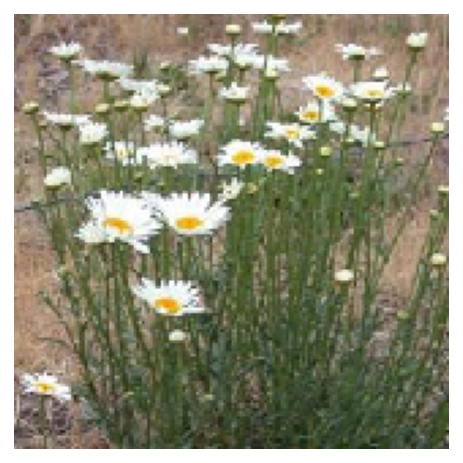

In [118]:

filename = 'daisy3.jpg'
show_and_predict_image(img_dir_path, filename)


This image seems 8.0% dandelion, and 0.0% daisy.
And it's 89.0% tulips, 0.0% sunflowers and finally 3.0% roses.


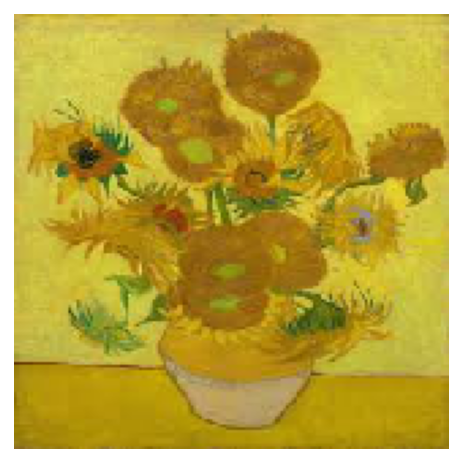

In [119]:

filename = 'sunf2.jpeg'
show_and_predict_image(img_dir_path, filename)


This image seems 17.0% dandelion, and 1.0% daisy.
And it's 63.0% tulips, 0.0% sunflowers and finally 19.0% roses.


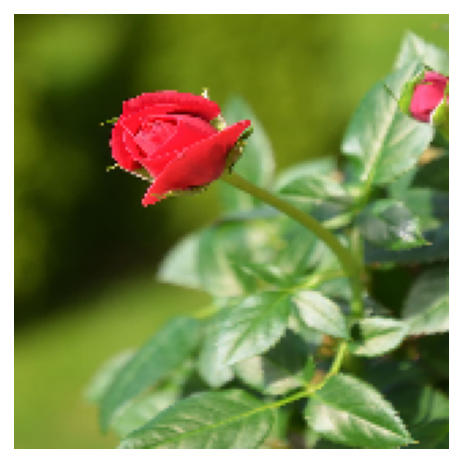

In [120]:

filename = 'roses2.jpg'
show_and_predict_image(img_dir_path, filename)